Importação de bibliotecas utilizadas

In [10]:

from numpy import NaN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

Importação dos dados a serem utilizados. Devido a exigência de ter apenas 10% dos dados para teste, foi optado por juntar novamente os dados para que pudessem ser separados da forma desejada.

In [11]:
data_test = 'hepatitis.data.test.csv'
data_train = 'hepatitis.data.train.csv'

data_test = pd.read_csv(data_test, sep=',')
data_train = pd.read_csv(data_train, sep=',')
completeData = pd.concat([data_test,data_train])

Função para plotar a curva ROC, baseada da documentação do scikit-learn

In [12]:
def plot_roc_curve(fpr, tpr,auc):
    plt.plot(fpr, tpr, color='blue', label='ROC, AUC = ' + str(auc))
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

Tratamento de dados
    - remover linhas que contenham os valores com '?'
    - a falta de informação de uma das colunas pode atrapalhar a previsão
    - transformar dados em float, para que possam ser calculadas as médias e desvio padrões

In [13]:
completeData = completeData.replace('?', NaN)

for col in completeData.columns:
    completeData = completeData[completeData[col].notna()]

completeData = completeData.reset_index(drop=True)
completeData = completeData.astype(float)

Informação completa de todos os dados

In [14]:
describe = completeData.describe()
describe

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,CLASS
count,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000
mean,40.66250,1.137500,1.525000,1.737500,1.350000,1.612500,1.850000,1.837500,1.525000,1.812500,1.687500,1.850000,1.875000,1.221250,102.912500,82.025000,3.843750,62.512500,1.41250,1.837500
std,11.28003,0.346547,0.502525,0.442769,0.479979,0.490253,0.359324,0.371236,0.502525,0.392775,0.466437,0.359324,0.332805,0.875213,53.684779,71.599974,0.576292,23.427774,0.49539,0.371236
min,20.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.300000,26.000000,14.000000,2.100000,0.000000,1.00000,1.000000
25%,32.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.700000,68.250000,30.750000,3.500000,46.000000,1.00000,2.000000
50%,38.50000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,85.000000,56.500000,4.000000,62.000000,1.00000,2.000000
75%,49.25000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.300000,133.500000,102.750000,4.200000,77.250000,2.00000,2.000000
max,72.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.800000,280.000000,420.000000,5.000000,100.000000,2.00000,2.000000


Gráficos de média e desvio padrão de todos os dados

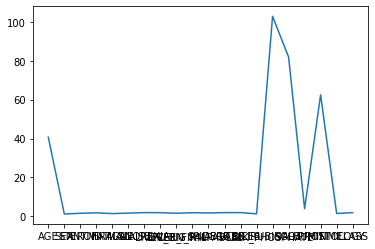

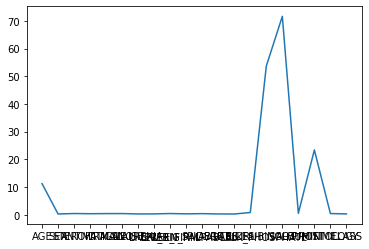

In [15]:
plt.plot(completeData.mean())
plt.show()

plt.plot(completeData.std())
plt.show()

Separando os dados de entrada e de saida e organizando 90% dos dados para treinamento e 10% dos dados para teste.
A biblioteca train_test_split escolhe as linhas aleatoriamente

In [16]:
X = completeData.iloc[:,0:19]
Y = completeData.iloc[:,19]

### Organizando 90% dos dados para treinamento e 10% dos dados para teste
# A biblioteca train_test_split escolhe as linhas aleatoriamente
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1)

Funções com os modelos a serem utilizados

In [17]:
def DecisionTree(X_train,Y_train,X_test):
    # o sklearn utiliza o modelo de CART (gini) e entropia e ganho (entropy)
    p_grid = {'criterion':['entropy']}
    model = DecisionTreeClassifier()    
    # Seleciona o melhor estimador encontrado e realiza a predicao
    grid_search_cv = GridSearchCV(model, p_grid, cv=10, scoring='accuracy', refit=True)
    result = grid_search_cv.fit(X_train, Y_train)
    best_model = result.best_estimator_
    pred = best_model.predict(X_test)
    return pred, best_model

In [18]:
def RandomForest(X_train,Y_train,X_test):
    # o sklearn utiliza o modelo de CART (gini) e entropia e ganho (entropy)
    p_grid = {'criterion':['entropy'],'n_estimators' : [100]}
    model = RandomForestClassifier()
    ### Utilizando o modelo de validacao cruzada para treinamento
    # Seleciona o melhor estimador encontrado e realiza a predicao
    grid_search_cv = GridSearchCV(model, p_grid, cv=10, scoring='accuracy', refit=True)
    result = grid_search_cv.fit(X_train, Y_train)
    best_model = result.best_estimator_
    pred = best_model.predict(X_test)
    return pred, best_model


In [19]:
def RandomForestSQRT(X_train,Y_train,X_test):
    X_train = X_train**2 
    # o sklearn utiliza o modelo de CART (gini) e entropia e ganho (entropy)
    p_grid = {'criterion':['entropy'],'n_estimators' : [100]}
    model = RandomForestClassifier()
    ### Utilizando o modelo de validacao cruzada para treinamento
    # Seleciona o melhor estimador encontrado e realiza a predicao
    grid_search_cv = GridSearchCV(model, p_grid, cv=10, scoring='accuracy', refit=True)
    result = grid_search_cv.fit(X_train, Y_train)
    best_model = result.best_estimator_
    pred = best_model.predict(X_test)
    return pred, best_model

In [20]:
predDT, best_modelDT = DecisionTree(X_train,Y_train,X_test)
predRF, best_modelRF = RandomForest(X_train,Y_train,X_test)
predRF2, best_modelRF2 = RandomForestSQRT(X_train,Y_train,X_test)

Criação da curva roc para cada modelo e matriz de confusão

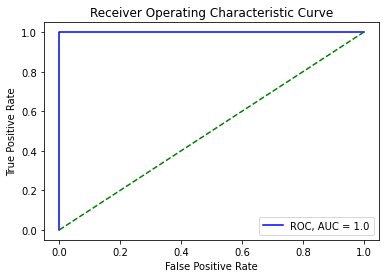

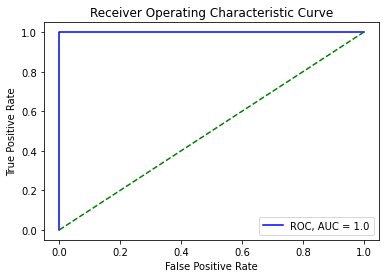

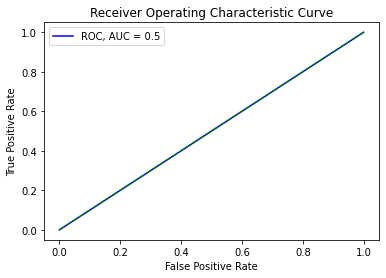

In [21]:
fpr, tpr, _ = roc_curve(Y_test, predDT, pos_label = 2)
auc = roc_auc_score(Y_test, predDT)
plot_roc_curve(fpr, tpr,auc)
fpr, tpr, _ = roc_curve(Y_test, predRF, pos_label = 2)
auc = roc_auc_score(Y_test, predRF)
plot_roc_curve(fpr, tpr,auc)
fpr, tpr, _ = roc_curve(Y_test, predRF2, pos_label = 2)
auc = roc_auc_score(Y_test, predRF2)
plot_roc_curve(fpr, tpr,auc)


Os dois primeiros modelos conseguiram prever os dados de maneira 100% correta, tendo apenas a diagonal principal com números maior que zero.
Já o terceiro modelo apresentou um resultado pior em que preveu todos os resultados como a mesma saída. 

In [22]:
confusion_matrixDT = pd.crosstab(Y_test, predDT, rownames=['Actual'], colnames=['Predicted'])
confusion_matrixRF = pd.crosstab(Y_test, predRF, rownames=['Actual'], colnames=['Predicted'])
confusion_matrixRF2 = pd.crosstab(Y_test, predRF2, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrixDT)
print(confusion_matrixRF)
print(confusion_matrixRF2)

Predicted  1.0  2.0
Actual             
1.0          1    0
2.0          0    7
Predicted  1.0  2.0
Actual             
1.0          1    0
2.0          0    7
Predicted  2.0
Actual        
1.0          1
2.0          7


Conferência do melhor modelo

O modelo de floresta randomica apresenta mais vezes o resultado com acurácia de 100%.

In [23]:
models = [RandomForestClassifier(),DecisionTreeClassifier()]
# score de cada modelo
models_scores = []
for model in models:
    val_scores = cross_val_score(model, X_train, Y_train, cv=10)
    nome_modelo = type(model).__name__ # somente para exibição
    print('Modelo: {} | Média: {:.2} | Desvio: {:.2}'.format(nome_modelo,
                                    np.mean(val_scores), np.std(val_scores)))
    print(val_scores)

Modelo: RandomForestClassifier | Média: 0.86 | Desvio: 0.11
[0.875      0.75       1.         0.71428571 1.         0.85714286
 0.85714286 0.71428571 1.         0.85714286]
Modelo: DecisionTreeClassifier | Média: 0.81 | Desvio: 0.089
[0.75       0.75       1.         0.85714286 0.85714286 0.71428571
 0.71428571 0.71428571 0.85714286 0.85714286]


Arvore de decisão para todos os modelos, para floresta randomica, foi considerada a última árvore criada

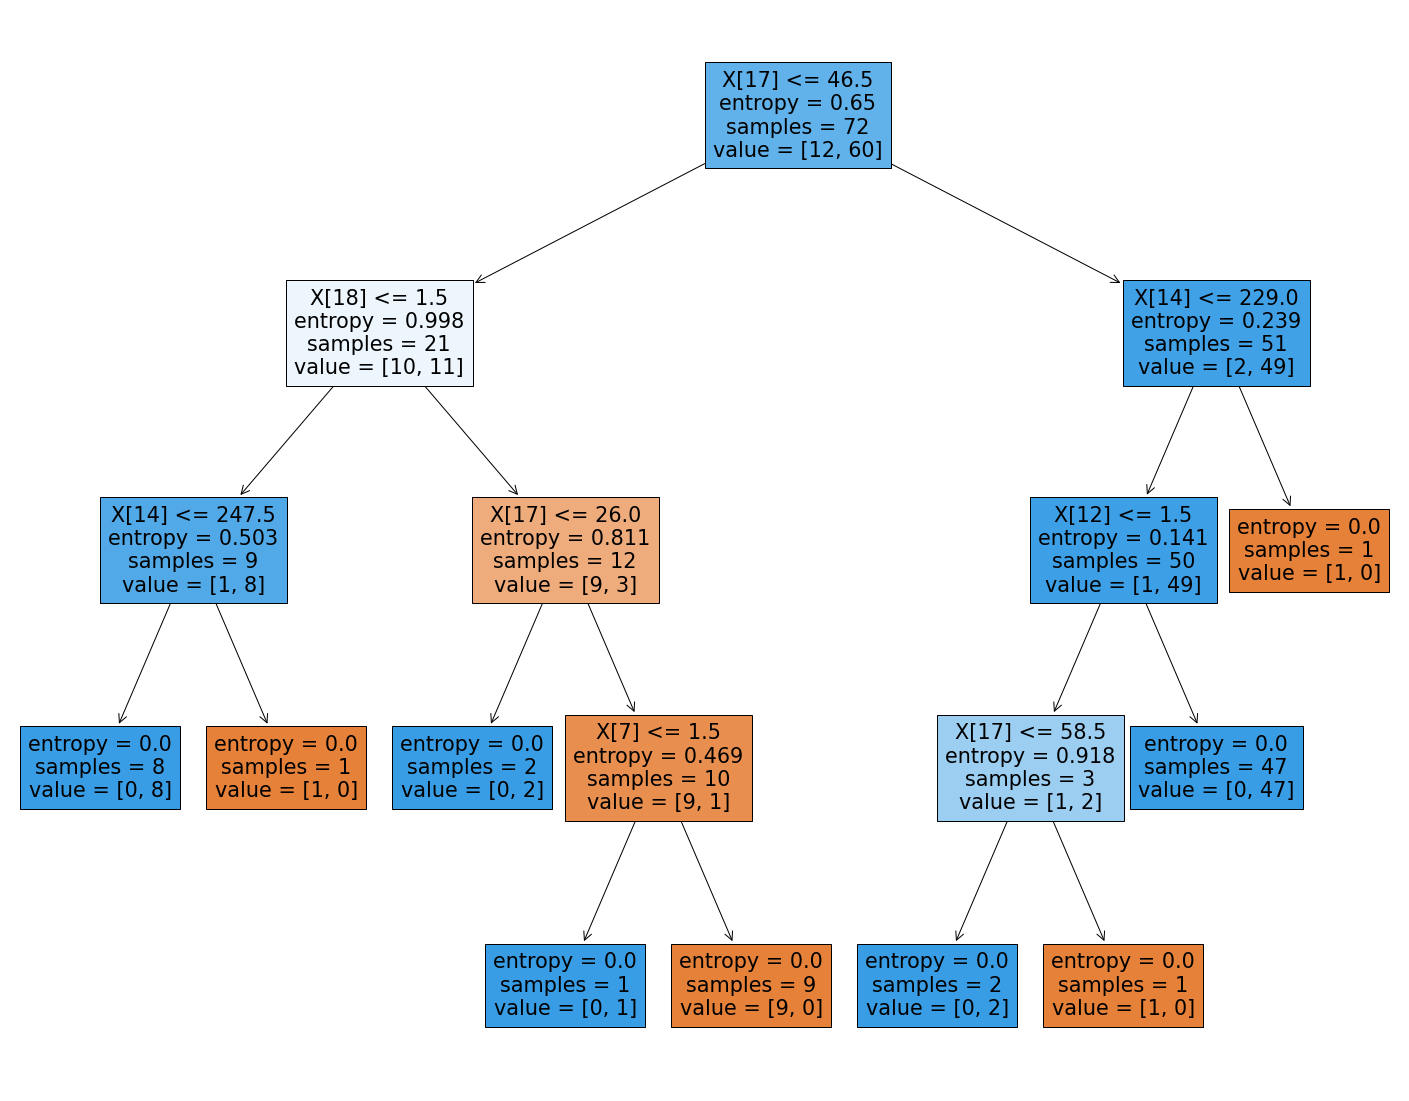

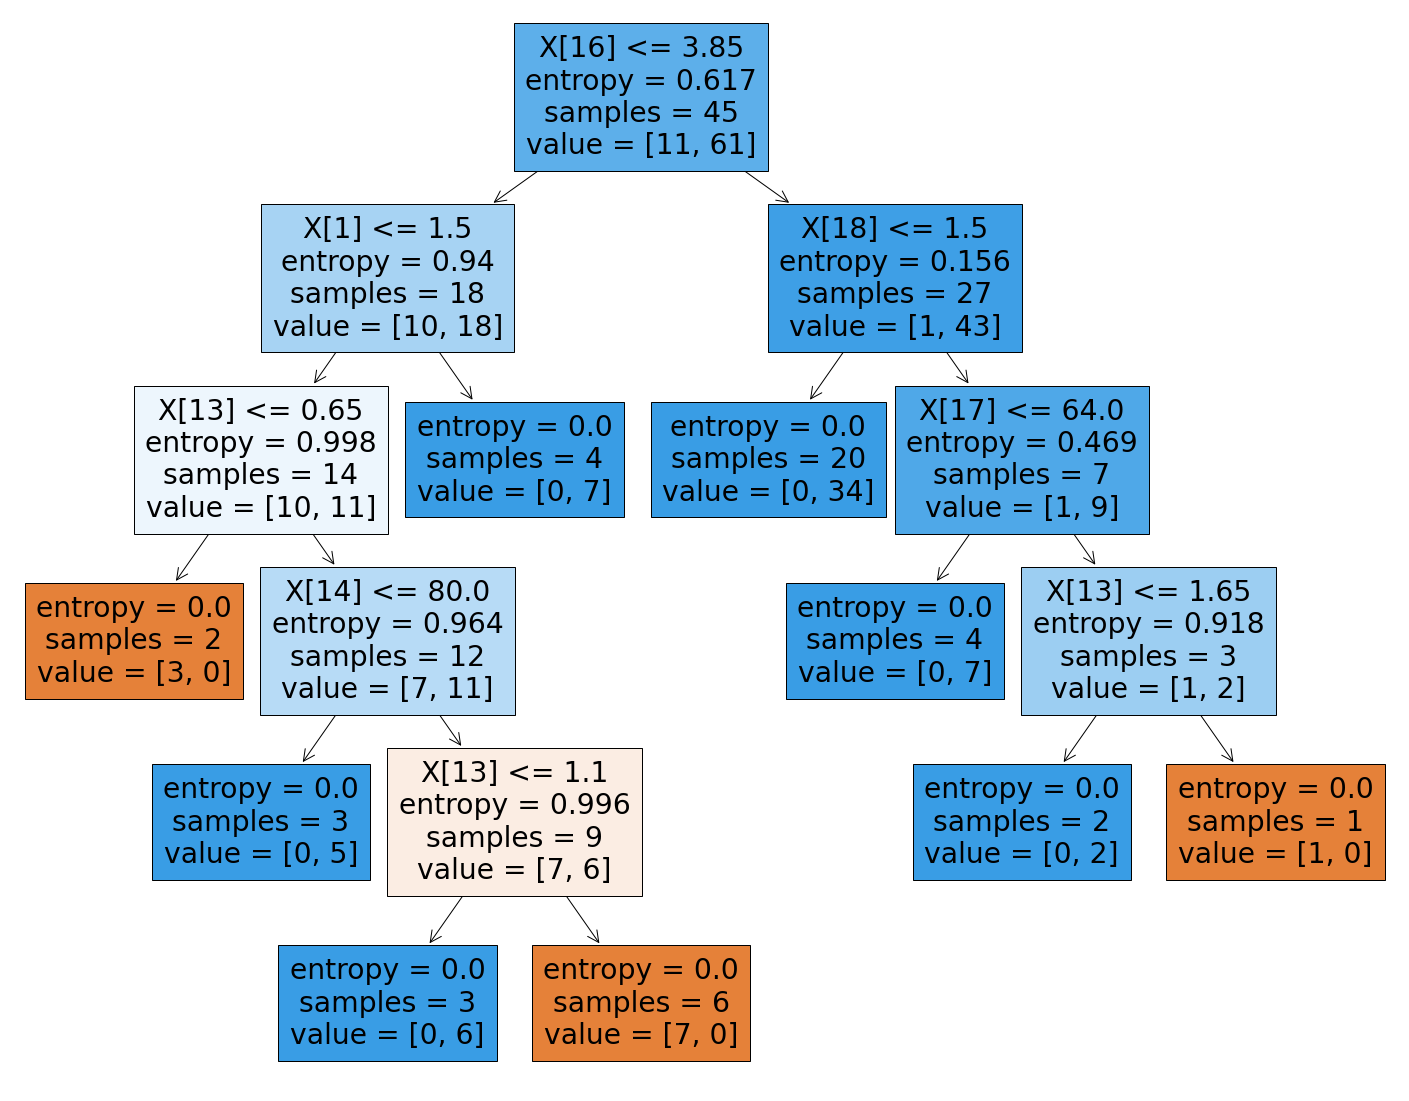

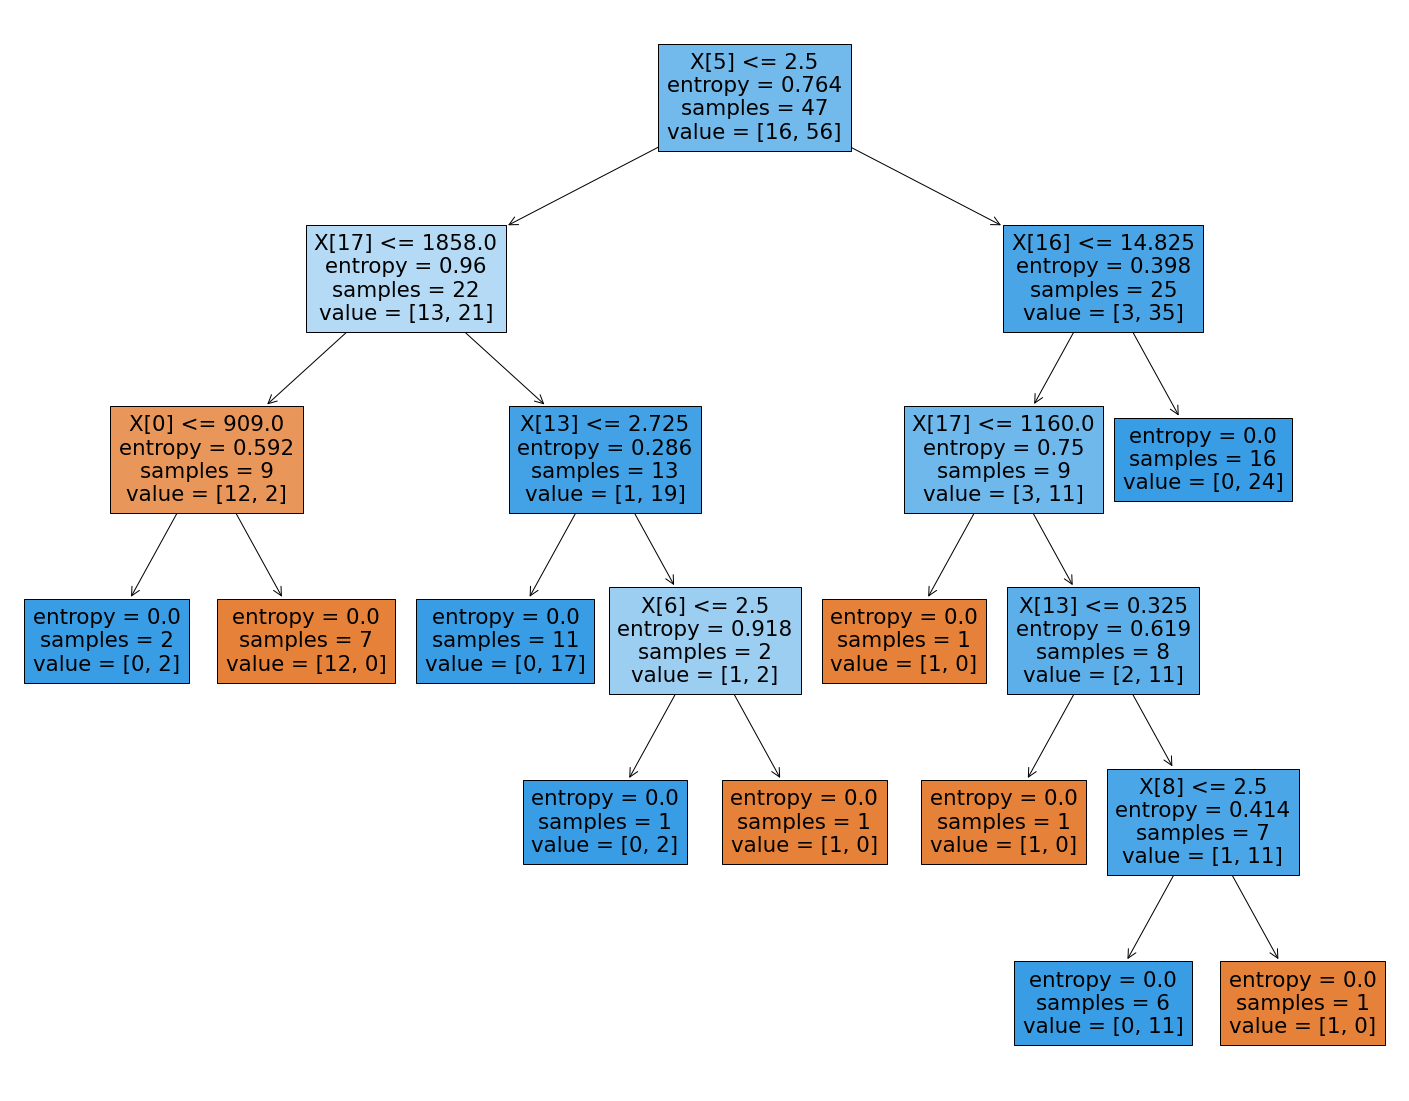

In [24]:
figDT = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_modelDT, filled=True)
figDT.savefig("DecisionTree.png")


figRF = plt.figure(figsize=(25,20))
tree.plot_tree(best_modelRF.estimators_[99], filled=True)
figRF.savefig("RandomForest.png")


figRF2 = plt.figure(figsize=(25,20))
tree.plot_tree(best_modelRF2.estimators_[99], filled=True)
figRF2.savefig("RandomForest2.png")

Para o caso de árvores de decisão, que obteve uma precisão de 100% nesse treinamento, as variáveis mais consideradas foram as colunas 17, 18 e 19 (ALBUMIN,PROTIME,HISTOLOGY)
Para florestas randômicas, também obteve uma precisão de 100% nesse treinamento, as variáveis mais consideradas foram as colunas 1, 16 e 18 (AGE,SGOT,PROTIME)
Ao elevar os dados de treinamento ao quadrado, a floresta randômica apresentou um resultado pior, com uma AUC de 0.5 , as variáveis mais consideradas foram as colunas 5, 16 e 17 (FATIGUE,SGOT,ALBUMIN)